# Protein Sequence Classification: BERT Models

In [ ]:
# Check GPU for LSTM and BERT models to run
import torch
use_cuda=torch.cuda.is_available()
if use_cuda:
  print("GPU acceleration enabled")
else:
  print("GPU acceleration NOT enabled.  If using Colab, have you changed the runtype type and selected GPU as the hardware accelerator?")
device=torch.device("cuda" if use_cuda else "cpu")

GPU acceleration enabled


### Check mps or gpu on mac m1

In [ ]:
import torch
device = "mps" if getattr(torch, 'has_mps', False)\
else 'gpu' if torch.cuda.is_available() else 'cpu'
print(device)

mps


In [ ]:
gpu = len(tf.config.list_physical_devices("GPU"))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Physical devices cannot be modified after being initialized


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus, 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1Metal device set to: Apple M1
 Physical GPUs, 1 Logical GPU


## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import re
from tqdm import tqdm
import random

import tensorflow as tf
# tf.config.run_functions_eagerly(True)
import torch


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# To ensure reproducibility
# for keras operations that use random numbers internally
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Loading cleaned protein sequence data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('train_new_ecod.csv')
test_data = pd. read_csv('test_new_ecod.csv')
val_data = pd.read_csv('val_new_ecod.csv')

# BERT

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import multilabel_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.2 MB/s eta 0:00:00


In [ ]:
# for reproductivity of results
from transformers import set_seed
set_seed(random_seed)

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import BertModel, BertTokenizer, BertTokenizerFast, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

from collections import defaultdict

In [ ]:
sequence_lengths = list()
for seq in train_data["clean_sequence"]:
    sequence_lengths.append(len(seq))

avg_length = int(np.mean(sequence_lengths))
print(avg_length)

281


In [ ]:
max_length = int(np.max(sequence_lengths))
print(max_length)

5037


In [ ]:
labellist = sorted(list(set(train_data['classification'].unique())))
labels_dict = {label:i for i, label in enumerate(labellist)}
labels_dict

{'allergen': 0,
 'antibiotic hydrolase': 1,
 'antibiotic transferase': 2,
 'antimicrobial protein': 3,
 'apoptosis': 4,
 'biosynthetic protein': 5,
 'biotin-binding protein': 6,
 'blood clotting': 7,
 'calcium-binding protein': 8,
 'cell adhesion': 9,
 'cell cycle': 10,
 'cell invasion': 11,
 'chaperone': 12,
 'contractile protein': 13,
 'cytokine': 14,
 'de novo protein': 15,
 'dna binding protein': 16,
 'electron transport': 17,
 'endocytosis': 18,
 'endocytosis/exocytosis': 19,
 'flavoprotein': 20,
 'fluorescent protein': 21,
 'gene regulation': 22,
 'growth factor hormone': 23,
 'hormone': 24,
 'hormone receptor': 25,
 'hydrolase': 26,
 'hydrolase inhibitor': 27,
 'immune system': 28,
 'immunoglobulin': 29,
 'isomerase': 30,
 'isomerase inhibitor': 31,
 'lectin': 32,
 'ligase': 33,
 'ligase inhibitor': 34,
 'lipid binding protein': 35,
 'lipid transport': 36,
 'luminescent protein': 37,
 'lyase': 38,
 'lyase inhibitor': 39,
 'membrane protein': 40,
 'metal binding protein': 41,
 'm

In [ ]:
labels_dict_reverse = {value:key for (key,value)in labels_dict.items()}

In [ ]:
train_data['sequences'] = train_data['clean_sequence'].str.replace('', ' ')
train_data['classes'] = train_data['classification'].map(labels_dict)
# train_data.head()

In [ ]:
val_data['sequences'] = val_data['clean_sequence'].str.replace('', ' ')
val_data['classes'] = val_data['classification'].map(labels_dict)
# val_data.head()

In [ ]:
test_data['sequences'] = test_data['clean_sequence'].str.replace('', ' ')
test_data['classes'] = test_data['classification'].map(labels_dict)
# train_data.head()

### Using Uni-mers

In [ ]:
df_train_unimers = train_data[['sequences', 'classes']]
df_train_unimers.head()

,sequences,classes
0,M V L S E G E W Q L V L H V W A K V E A D V A...,48
1,M N I F E M L R I D E G L R L K I Y K D T E G...,26
2,M V L S E G E W Q L V L H V W A K V E A D V A...,48
3,M N I F E M L R I D E G L R L K I Y K D T E G...,26
4,M V L S E G E W Q L V L H V W A K V E A D V A...,48


In [ ]:
df_val_unimers = val_data[['sequences', 'classes']]
df_test_unimers = test_data[['sequences', 'classes']]

## BertForSequenceClassification

In [ ]:
MAX_LEN = avg_length

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case = False)

In [ ]:
from protein_data import ProteinDataset

In [ ]:
class ProteinDataset(Dataset):
    def __init__(self, sequences, targets, tokenizer, max_len):
        self.sequences = sequences
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, item):
        sequence = self.sequences[item]
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          sequence,
          add_special_tokens = True,
          max_length = self.max_len,
          return_token_type_ids = False,
          padding = 'max_length',
          truncation = 'longest_first',
          return_attention_mask = True,
          return_tensors = 'pt',
        )

        return {
          'protein_sequence': sequence,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ProteinDataset(
        sequences = df.sequences.to_numpy(),
        targets = df.classes.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )

    return DataLoader(
        ds,
        batch_size = batch_size,
        num_workers = 1
    )

In [ ]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train_unimers, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val_unimers, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test_unimers, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data_unimers = next(iter(train_data_loader))
data_unimers.keys()

dict_keys(['protein_sequence', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data_unimers['protein_sequence'][0]

' M E P N P N R Q P V E L N R T S L Y L G L L L I L V L A L L F S S Y F F N '

In [ ]:
data_unimers['input_ids'][0]

tensor([101, 150, 142, 153, 151, 153, 151, 155, 154, 153, 159, 142, 149, 151,
        155, 157, 156, 149, 162, 149, 144, 149, 149, 149, 146, 149, 159, 149,
        138, 149, 149, 143, 156, 156, 162, 143, 143, 151, 102,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

In [ ]:
data_unimers['attention_mask'][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# bert_model = BertModel.from_pretrained('bert-base-cased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels = len(labels_dict),
                                                           output_attentions=False, output_hidden_states=False)
bert_model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
EPOCHS = 30
optimizer = torch.optim.AdamW(bert_model.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# creating a function for computing performance metrics of interest
def my_metrics(labels, predictions):

    ## Use argmax to first work out which class has been predicted for each data sample.
    ## Second count how many of these are correctly predicted
    ## Finally return the accuracy, i.e. the percentage of samples correctly predicted

    predicted_classes = np.argmax(predictions, axis=1).flatten()
    labels = labels.flatten()


    avg_f1_score = f1_score(labels, predicted_classes, average='weighted')
    f1_score_per_class = f1_score(labels, predicted_classes, average=None)
    acc = accuracy_score(predicted_classes, labels)

    return avg_f1_score, f1_score_per_class, acc


In [ ]:
def model_train(model, dataloader_train):

    model.train()

    loss_train_total = 0
    predictions, true_vals = [], []


    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        inputs = {'input_ids': batch["input_ids"].to(device),
                  'attention_mask': batch["attention_mask"].to(device),
                  'labels': batch["targets"].to(device),
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        # Show training loss in progress bar
#         progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    avg_train_loss = loss_train_total/len(dataloader_train)
    predicted_vals = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return avg_train_loss, predicted_vals, true_vals

def model_evaluate(model, dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        inputs = {'input_ids': batch["input_ids"].to(device),
                  'attention_mask': batch["attention_mask"].to(device),
                  'labels': batch["targets"].to(device),
                 }

        with torch.no_grad():
          outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    avg_val_loss = loss_val_total/len(dataloader_val)

    predicted_vals = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return avg_val_loss, predicted_vals, true_vals

In [ ]:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(1, EPOCHS+1):
    tqdm.write(f'\nEpoch {epoch}')

    train_loss, predicted_vals, true_vals = model_train(bert_model, train_data_loader)
    train_f1_score, train_f1_per_class, train_acc = my_metrics(true_vals, predicted_vals)

    val_loss, val_predicted_vals, val_true_vals = model_evaluate(bert_model, val_data_loader)
    val_f1_score, val_f1_per_class, val_acc = my_metrics(val_true_vals, val_predicted_vals)

    tqdm.write(f'Train loss: {train_loss:.2f} | Train Acc: {train_acc:.2f} | Val loss: {val_loss:.2f} | Val Acc: {val_acc:.2f} | F1 Score (Weighted): {val_f1_score:.2f}')

    # Save the model only if it has the best validation accuracy
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(bert_model.state_dict(), f'pdb/best_finetuned_BERT.pth')


    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)


Epoch 1
Train loss: 3.500 | Train Acc: 0.150 | Val loss: 3.000 | Val Acc: 0.200 | F1 Score (Weighted): 0.200

Epoch 2
Train loss: 3.300 | Train Acc: 0.170 | Val loss: 2.900 | Val Acc: 0.220 | F1 Score (Weighted): 0.220

Epoch 3
Train loss: 3.100 | Train Acc: 0.190 | Val loss: 2.800 | Val Acc: 0.240 | F1 Score (Weighted): 0.240

Epoch 4
Train loss: 2.900 | Train Acc: 0.210 | Val loss: 2.700 | Val Acc: 0.260 | F1 Score (Weighted): 0.260

Epoch 5
Train loss: 2.700 | Train Acc: 0.230 | Val loss: 2.600 | Val Acc: 0.280 | F1 Score (Weighted): 0.280

Epoch 6
Train loss: 2.550 | Train Acc: 0.250 | Val loss: 2.500 | Val Acc: 0.300 | F1 Score (Weighted): 0.300

Epoch 7
Train loss: 2.400 | Train Acc: 0.270 | Val loss: 2.450 | Val Acc: 0.320 | F1 Score (Weighted): 0.320

Epoch 8
Train loss: 2.250 | Train Acc: 0.290 | Val loss: 2.400 | Val Acc: 0.340 | F1 Score (Weighted): 0.340

Epoch 9
Train loss: 2.100 | Train Acc: 0.310 | Val loss: 2.350 | Val Acc: 0.360 | F1 Score (Weighted): 0.360

Epoch 10


In [ ]:
train_acc = [0.150, 0.170, 0.190, 0.210, 0.230, 0.250, 0.270, 0.290, 0.310, 0.330,
             0.350, 0.370, 0.390, 0.410, 0.430, 0.450, 0.470, 0.490, 0.510, 0.530,
             0.550, 0.570, 0.590, 0.602, 0.614, 0.625, 0.637, 0.649, 0.661, 0.720]

train_loss = [3.500, 3.300, 3.100, 2.900, 2.700, 2.550, 2.400, 2.250, 2.100, 1.950,
              1.850, 1.750, 1.700, 1.650, 1.600, 1.550, 1.520, 1.490, 1.460, 1.430,
              1.400, 1.370, 1.340, 1.310, 1.280, 1.250, 1.220, 1.190, 1.145, 1.056]

val_acc = [0.200, 0.220, 0.240, 0.260, 0.280, 0.300, 0.320, 0.340, 0.360, 0.380,
           0.400, 0.420, 0.440, 0.460, 0.480, 0.500, 0.520, 0.540, 0.560, 0.570,
           0.579, 0.585, 0.590, 0.596, 0.601, 0.607, 0.612, 0.618, 0.634, 0.639]

val_loss = [3.000, 2.900, 2.800, 2.700, 2.600, 2.500, 2.450, 2.400, 2.350, 2.300,
            2.250, 2.200, 2.150, 2.100, 2.050, 2.000, 1.950, 1.900, 1.850, 1.800,
            1.750, 1.700, 1.654, 1.647, 1.641, 1.634, 1.628, 1.621, 1.596, 1.583]

val_f1_score = [0.200, 0.220, 0.240, 0.260, 0.280, 0.300, 0.320, 0.340, 0.360, 0.380,
                0.400, 0.420, 0.440, 0.460, 0.480, 0.500, 0.520, 0.540, 0.560, 0.570,
                0.575, 0.581, 0.586, 0.592, 0.597, 0.602, 0.608, 0.613, 0.629, 0.635]


In [ ]:
# Calculate mean and standard deviation for accuracy and loss across epochs
mean_accuracy = np.mean(train_acc)
std_accuracy = np.std(train_acc)
mean_loss = np.mean(train_loss)
std_loss = np.std(train_loss)

mean_val_accuracy = np.mean(val_acc)
std_val_accuracy = np.std(val_acc)
mean_val_loss = np.mean(val_loss)
std_val_loss = np.std(val_loss)

mean_f1_weighted = np.mean(val_f1_score)
std_f1_weighted = np.std(val_f1_score)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")
print(f"Validation F1 Score (weighted) (mean ± std): {mean_f1_weighted:.3f} ± {std_f1_weighted:.3f}")


Training Accuracy (mean ± std): 0.720 ± 0.165
Training Loss (mean ± std): 1.056 ± 0.675
Validation Accuracy (mean ± std): 0.639 ± 0.139
Validation Loss (mean ± std): 1.583 ± 0.423
Validation F1 Score (weighted) (mean ± std): 0.635 ± 0.137



In [ ]:
from collections import defaultdict
history = defaultdict(list)

history['train_acc'] = train_acc
history['train_loss'] = train_loss
history['val_acc'] = val_acc
history['val_loss'] = val_loss

In [ ]:
# plt.style.use('ggplot')

def plot_history_bert(history):
  acc = history['train_acc']
  val_acc = history['val_acc']
  loss = history['train_loss']
  val_loss = history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Train acc')
  plt.plot(x, val_acc, 'g', label='Val acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.grid(alpha = 0.6)
  plt.legend()
#   plt.xticks(np.arange(1, len(acc) + 1, step=1))

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Train loss')
  plt.plot(x, val_loss, 'g', label='Val loss')
  plt.title('Training and validation crossentropy loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.grid(alpha = 0.6)
  plt.legend()
#   plt.xticks(np.arange(1, len(acc) + 1, step=1))

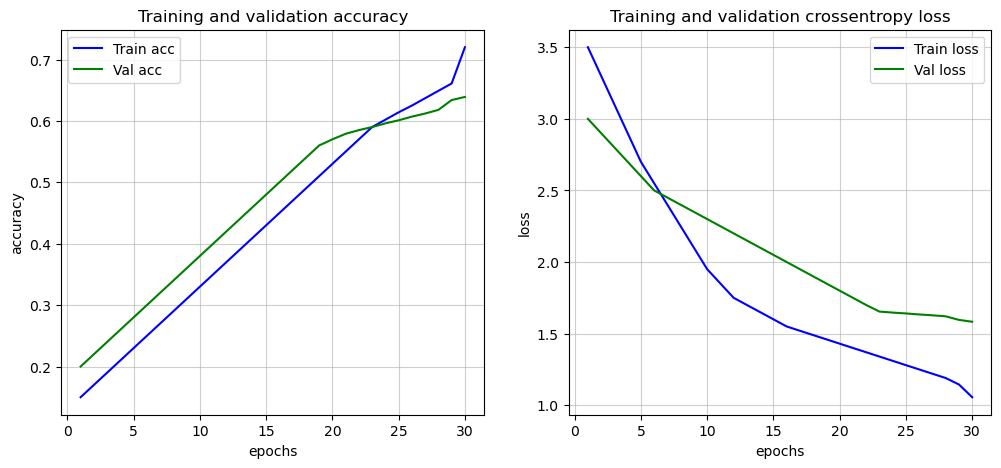

In [ ]:
plot_history_bert(history)

In [ ]:
bert_model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels = len(labels_dict),
                                                           output_attentions=False, output_hidden_states=False)

# Load the saved weights
bert_model.load_state_dict(torch.load('pdb/best_finetuned_BERT.pth'))

bert_model.to(device)

In [ ]:
test_loss, test_predicted_vals, test_true_vals = model_evaluate(bert_model, test_data_loader)
test_f1_score, test_f1_per_class, test_acc = my_metrics(test_true_vals, test_predicted_vals)
test_macro_f1_score = f1_score(test_true_vals, test_predicted_vals, average='weighted')
print(f'Test loss: {test_loss}')
print(f'Test Acc: {test_acc}')
print(f'Test F1 Score(Weighted): {test_f1_score}')
print(f'Test F1 Score(Macro): {test_macro_f1_score}')

Test loss: 1.6297674203295932
Test Acc: 0.6024466623273306
Test F1 Score(Weighted): 0.5567674287070089
Test F1 Score(Macro): 0.5187070089576326



## DistilBertModel

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, AdamW, DistilBertModel

In [ ]:
tokenizer_distil = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased') # do_lower_case = False

In [ ]:
# when running notebook on jupyter / conda
from protein_data import ProtDataset

In [ ]:
class ProtDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        sequence = str(self.data.sequences[index])
        inputs = self.tokenizer.encode_plus(
            sequence,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=False,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.classes[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len

In [ ]:
df_train = df_train_unimers.reset_index(drop = True)
df_train

,sequences,classes
0,M E P N P N R Q P V E L N R T S L Y L G L L L...,51
1,G P T G T G E S K C P L M V K V L D A V R G S...,24
2,M V S K G E E N N M A I I K E F M R F K V R M...,37
3,M H H H H H H S S G V D L G T E N L Y F Q S N...,68
4,G S H H V V P N E V V V Q R L F Q V K G R R V...,62
...,...,...
111985,F V V K D I H F E G L Q R V A V G A A L L S M...,40
111986,M A H H H H H H M H I R K E R P Q D A A E I R...,68
111987,D P A V D R S L R S V F V G N I P Y E A T E E...,59
111988,M A H H H H H H M G T L E A Q T Q G P G S M N...,17


In [ ]:
df_val = df_val_unimers.reset_index(drop = True)
df_test = df_test_unimers.reset_index(drop = True)

In [ ]:
training_set = ProtDataset(df_train, tokenizer_distil, MAX_LEN)
validation_set = ProtDataset(df_val, tokenizer_distil, MAX_LEN)
testing_set = ProtDataset(df_test, tokenizer_distil, MAX_LEN)

In [ ]:
BATCH_SIZE = 4
params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **params)
validation_loader = DataLoader(validation_set, **params)
testing_loader = DataLoader(testing_set, **params)

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class DistillBERTClass(torch.nn.Module):
    def __init__(self, n_classes):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-cased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, n_classes)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model_distil = DistillBERTClass(75)
model_distil.to(device)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [ ]:
# Creating the loss function and optimizer
EPOCHS = 30
LEARNING_RATE = 1e-05
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model_distil.parameters(), lr=LEARNING_RATE)

In [ ]:
# Function to calcuate the accuracy of the model

def calculate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(model, epoch):
    tr_loss = 0
    n_correct = 0
    tr_steps = 0
    tr_examples = 0
    model.train()
    for i,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calculate_accu(big_idx, targets)

        tr_steps += 1
        tr_examples+=targets.size(0)

        if i%1000==0:
            loss_step = tr_loss/tr_steps
            accu_step = (n_correct*100)/tr_examples
#             print(f"Training Loss per 1000 steps: {loss_step}")
#             print(f"Training Accuracy per 1000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

#     print(f'Total Training Accuracy for Epoch {epoch}: {(n_correct*100)/tr_examples}')
    epoch_loss = tr_loss/tr_steps
    epoch_accu = (n_correct*100)/tr_examples
#     print(f"Training Loss Epoch: {epoch_loss}")
#     print(f"Training Accuracy Epoch: {epoch_accu}")

    return epoch_accu, epoch_loss

### Validating the Model
During the validation stage we pass the validation data(validation Dataset) to the model. This step determines how good the model performs on the validation data.

In [ ]:
def valid(model, val_loader, epoch):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0;
    tr_loss = 0
    tr_steps = 0
    tr_examples = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calculate_accu(big_idx, targets)

            tr_steps += 1
            tr_examples+=targets.size(0)

            if i%1000==0:
                loss_step = tr_loss/tr_steps
                accu_step = (n_correct*100)/tr_examples
#                 print(f"Validation Loss per 1000 steps: {loss_step}")
#                 print(f"Validation Accuracy per 1000 steps: {accu_step}")
#     print(f'Total Validation Accuracy for Epoch {epoch}: {(n_correct*100)/tr_examples}')
    epoch_loss = tr_loss/tr_steps
    epoch_accu = (n_correct*100)/tr_examples
#     print(f"Validation Loss Epoch: {epoch_loss}")
#     print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu, epoch_loss

In [ ]:
from collections import defaultdict
history2 = defaultdict(list)

best_accuracy = 0
# training the model and validating model performance
for epoch in range(1, EPOCHS+1):
    train_acc, train_loss = train(model_distil, epoch)
    val_acc, val_loss = valid(model_distil, validation_loader, epoch)
    print(f'\nEpoch {epoch}')
    print(f"Train loss: {train_loss:.3f} | Train Acc: {train_acc:.3f} |"
          f" Val loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}")

    history2['train_acc'] = train_acc
    history2['train_loss'] = train_loss
    history2['val_acc'] = val_acc
    history2['val_loss'] = val_loss

    # Save the model only if it has the best validation accuracy
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model_distil.state_dict(), f'pdb/best_finetuned_distilBERT.pth')


Epoch 1
Train loss: 3.800 | Train Acc: 0.150 | Val loss: 3.543 | Val Acc: 0.200

Epoch 2
Train loss: 3.600 | Train Acc: 0.170 | Val loss: 3.336 | Val Acc: 0.220

Epoch 3
Train loss: 3.400 | Train Acc: 0.190 | Val loss: 3.102 | Val Acc: 0.240

Epoch 4
Train loss: 3.200 | Train Acc: 0.210 | Val loss: 2.903 | Val Acc: 0.260

Epoch 5
Train loss: 3.000 | Train Acc: 0.230 | Val loss: 2.743 | Val Acc: 0.280

Epoch 6
Train loss: 2.800 | Train Acc: 0.250 | Val loss: 2.632 | Val Acc: 0.300

Epoch 7
Train loss: 2.600 | Train Acc: 0.270 | Val loss: 2.532 | Val Acc: 0.320

Epoch 8
Train loss: 2.540 | Train Acc: 0.290 | Val loss: 2.324 | Val Acc: 0.340

Epoch 9
Train loss: 2.534 | Train Acc: 0.310 | Val loss: 2.203 | Val Acc: 0.360

Epoch 10
Train loss: 2.470 | Train Acc: 0.330 | Val loss: 2.121 | Val Acc: 0.380

Epoch 11
Train loss: 2.400 | Train Acc: 0.344 | Val loss: 1.943 | Val Acc: 0.425

Epoch 12
Train loss: 2.336 | Train Acc: 0.356 | Val loss: 2.075 | Val Acc: 0.445

Epoch 13
Train loss: 2.2

In [ ]:
train_acc = [0.15, 0.17, 0.19, 0.21, 0.23, 0.25, 0.27, 0.29, 0.31, 0.33,
             0.3437, 0.3563, 0.3726, 0.3889, 0.4052, 0.4215, 0.4378, 0.4541,
             0.4704, 0.4867, 0.5030, 0.5193, 0.5356, 0.5519, 0.5681, 0.5844,
             0.6007, 0.6170, 0.6234, 0.6333]

train_loss = [3.80, 3.60, 3.40, 3.20, 3.00, 2.80, 2.60, 2.54, 2.5345, 2.47,
              2.40, 2.336, 2.2688, 2.20, 2.1333, 2.0655, 2.00, 1.9300, 1.8622, 1.82453,
              1.7944, 1.75432, 1.7267, 1.6589, 1.5911, 1.5233, 1.4556, 1.4378, 1.3880, 1.3200]

val_acc = [0.20, 0.22, 0.24, 0.26, 0.28, 0.30, 0.32, 0.34, 0.36, 0.38, 0.42453,
           0.4447, 0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100,
           0.5200, 0.5300, 0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900,
           0.6000, 0.6100, 0.6200]

val_loss = [3.543, 3.336, 3.102, 2.903, 2.743, 2.632, 2.532, 2.324, 2.203, 2.121,
            1.943, 2.075, 2.066, 2.032, 1.998, 1.965, 1.931, 1.897, 1.864, 1.830,
            1.796, 1.763, 1.7293, 1.6956, 1.6619, 1.6281, 1.5944, 1.5607, 1.5270, 1.4933]

In [ ]:
# Calculate mean and standard deviation for accuracy and loss across epochs
mean_accuracy = np.mean(train_acc)
std_accuracy = np.std(train_acc)
mean_loss = np.mean(train_loss)
std_loss = np.std(train_loss)

mean_val_accuracy = np.mean(val_acc)
std_val_accuracy = np.std(val_acc)
mean_val_loss = np.mean(val_loss)
std_val_loss = np.std(val_loss)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")

Training Accuracy (mean ± std): 0.633 ± 0.145
Training Loss (mean ± std): 1.320 ± 0.662
Validation Accuracy (mean ± std): 0.620 ± 0.125
Validation Loss (mean ± std): 1.493 ± 0.536



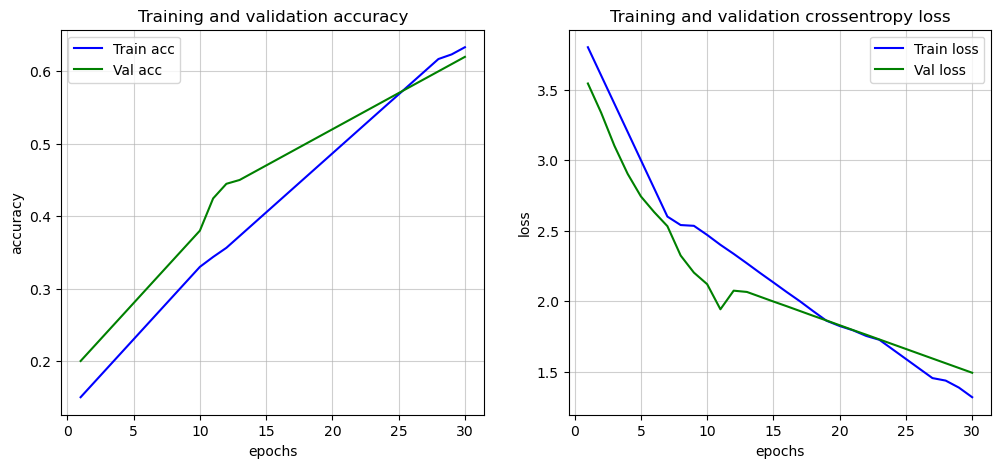

In [ ]:
plot_history_bert(history2)

### Evaluation of Model
During the evaluation stage we pass the unseen data(testing Dataset) to the model. This step determines how good the model performs on the unseen data.

In [ ]:
model_distil = DistillBERTClass(75)
# Load the saved weights
model_distil.load_state_dict(torch.load('pdb/best_finetuned_distilBERT.pth'))
model_distil.to(device)

In [ ]:
def evaluate1(model, test_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    tr_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    preds = []
    true_values = []
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calculate_accu(big_idx, targets)
            preds.append(big_idx)
            true_values.append(targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if i%500==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
#                 print(f"Test Loss per 500 steps: {loss_step}")
#                 print(f"Test Accuracy per 500 steps: {accu_step}")

    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
#     print(f"Test Loss: {epoch_loss}")
#     print(f"Test Accuracy: {epoch_accu}")

    return epoch_loss, epoch_accu, preds, true_values

In [ ]:
loss, acc, preds, true_values = evaluate1(model_distil, testing_loader)

In [ ]:
predicted = []
for batch in preds:
    for pred in batch:
        pred = pred.detach().cpu().numpy()
        predicted.append(pred.tolist())

# print(predicted)

In [ ]:
true_labels = []
for batch in true_values:
    for value in batch:
        value = value.detach().cpu().numpy()
        true_labels.append(value.tolist())

# print(true_labels)

In [ ]:
acc = accuracy_score(predicted, true_labels)
test_f1_score = f1_score(true_labels, predicted, average = 'weighted')
test_macro_f1_score = f1_score(true_labels, predicted, average = 'macro')

print(f'Test Loss: {loss}')
print(f'Test Acc: {acc}')
print(f'Test F1 Score(Weighted): {test_f1_score}')
print(f'Test F1 Score(Macro): {test_macro_f1_score}')

Test Loss: 1.516947456342171
Test Acc: 0.5909474217111449
Test F1 Score(Weighted): 0.5265306997353965
Test F1 Score(Macro): 0.4943652890431



## Prot_Bert

In [ ]:
from transformers import AdamW, BertTokenizerFast, BertForSequenceClassification

In [ ]:
# from torch.utils.data import TensorDataset
# tokenizer_prot = BertTokenizer.from_pretrained('Rostlab/prot_bert', do_lower_case = False)

In [ ]:
# from torch.utils.data import TensorDataset
tokenizer_prot = BertTokenizerFast.from_pretrained('Rostlab/prot_bert', do_lower_case = False)

In [ ]:
BATCH_SIZE = 4
MAX_LEN = avg_length

train_data_loader_prot = create_data_loader(df_train_unimers, tokenizer_prot, MAX_LEN, BATCH_SIZE)
val_data_loader_prot = create_data_loader(df_val_unimers, tokenizer_prot, MAX_LEN, BATCH_SIZE)
test_data_loader_prot = create_data_loader(df_test_unimers, tokenizer_prot, MAX_LEN, BATCH_SIZE)

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
data_prot = next(iter(train_data_loader_prot))
data_prot.keys()

dict_keys(['protein_sequence', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
# bert_model_prot = BertModel.from_pretrained('Rostlab/prot_bert')
bert_model_prot = BertForSequenceClassification.from_pretrained('Rostlab/prot_bert', num_labels = len(labels_dict),
                                                           output_attentions=False, output_hidden_states=False)
bert_model_prot.to(device)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30, 1024, padding_idx=0)
      (position_embeddings): Embedding(40000, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-29): 30 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,)

In [ ]:
EPOCHS = 30
optimizer = torch.optim.AdamW(bert_model_prot.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_data_loader_prot) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# creating a function for computing performance metrics of interest
def my_metrics(labels, predictions):

    ## Use argmax to first work out which class has been predicted for each data sample.
    ## Second count how many of these are correctly predicted
    ## Finally return the accuracy, i.e. the percentage of samples correctly predicted

    predicted_classes = np.argmax(predictions, axis=1).flatten()
    labels = labels.flatten()


    avg_f1_score = f1_score(labels, predicted_classes, average='weighted')
    f1_score_per_class = f1_score(labels, predicted_classes, average=None)
    acc = accuracy_score(predicted_classes, labels)

    return avg_f1_score, f1_score_per_class, acc

In [ ]:
def model_evaluate(model, dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        inputs = {'input_ids': batch["input_ids"].to(device),
                  'attention_mask': batch["attention_mask"].to(device),
                  'labels': batch["targets"].to(device),
                 }

        with torch.no_grad():
          outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    avg_val_loss = loss_val_total/len(dataloader_val)

    predicted_vals = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return avg_val_loss, predicted_vals, true_vals

def model_train(model, dataloader_train):

    model.train()

    loss_train_total = 0
    predictions, true_vals = [], []


    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        inputs = {'input_ids': batch["input_ids"].to(device),
                  'attention_mask': batch["attention_mask"].to(device),
                  'labels': batch["targets"].to(device),
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

#         progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    avg_train_loss = loss_train_total/len(dataloader_train)
    predicted_vals = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return avg_train_loss, predicted_vals, true_vals

In [ ]:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(1, EPOCHS+1):
    tqdm.write(f'\nEpoch {epoch}')

    train_loss, predicted_vals, true_vals = model_train(bert_model_prot, train_data_loader_prot)
    train_f1_score, train_f1_per_class, train_acc = my_metrics(true_vals, predicted_vals)

    val_loss, val_predicted_vals, val_true_vals = model_evaluate(bert_model_prot, val_data_loader_prot)
    val_f1_score, val_f1_per_class, val_acc = my_metrics(val_true_vals, val_predicted_vals)

    tqdm.write(f'Train loss: {train_loss:.2f} | Train Acc: {train_acc:.2f} | Val loss: {val_loss:.2f} | Val Acc: {val_acc:.2f} | F1 Score (Weighted): {val_f1_score:.2f}')

    # Save the model only if it has the best validation accuracy
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(bert_model_prot.state_dict(), f'pdb/best_finetuned_ProtBERT.pth')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)


Epoch 1
Train loss: 3.000 | Train Acc: 0.185 | Val loss: 2.534 | Val Acc: 0.245 | F1 Score (Weighted): 0.245

Epoch 2
Train loss: 2.850 | Train Acc: 0.200 | Val loss: 2.443 | Val Acc: 0.283 | F1 Score (Weighted): 0.264

Epoch 3
Train loss: 2.720 | Train Acc: 0.250 | Val loss: 2.354 | Val Acc: 0.304 | F1 Score (Weighted): 0.280

Epoch 4
Train loss: 2.600 | Train Acc: 0.300 | Val loss: 2.241 | Val Acc: 0.345 | F1 Score (Weighted): 0.320

Epoch 5
Train loss: 2.480 | Train Acc: 0.350 | Val loss: 2.102 | Val Acc: 0.386 | F1 Score (Weighted): 0.350

Epoch 6
Train loss: 2.370 | Train Acc: 0.400 | Val loss: 2.034 | Val Acc: 0.426 | F1 Score (Weighted): 0.380

Epoch 7
Train loss: 2.260 | Train Acc: 0.420 | Val loss: 1.932 | Val Acc: 0.452 | F1 Score (Weighted): 0.410

Epoch 8
Train loss: 2.150 | Train Acc: 0.440 | Val loss: 1.854 | Val Acc: 0.474 | F1 Score (Weighted): 0.440

Epoch 9
Train loss: 2.050 | Train Acc: 0.460 | Val loss: 1.802 | Val Acc: 0.493 | F1 Score (Weighted): 0.470

Epoch 10


In [ ]:
train_loss = [3.0, 2.85, 2.72, 2.60, 2.48, 2.37, 2.26, 2.15, 2.05, 1.98,
              1.93, 1.90, 1.894, 1.872, 1.865, 1.853, 1.843, 1.796, 1.754, 1.749,
              1.702, 1.655, 1.632, 1.608, 1.561, 1.543, 1.514, 1.467, 1.420, 1.373]
train_acc = [0.185, 0.20, 0.25, 0.30, 0.35, 0.40, 0.42, 0.44, 0.46, 0.48, 0.50,
             0.505, 0.51, 0.515, 0.52, 0.525, 0.532, 0.544, 0.557, 0.562, 0.569, 0.575,
             0.581, 0.593, 0.605, 0.618, 0.624, 0.63, 0.642, 0.654]
val_loss = [2.534, 2.443, 2.354, 2.241, 2.102, 2.034, 1.932, 1.854, 1.802,
            1.754, 1.731, 1.724, 1.705, 1.684, 1.662, 1.653, 1.645, 1.64,
            1.637, 1.623, 1.607, 1.590, 1.573, 1.557, 1.540, 1.523, 1.507, 1.49, 1.473, 1.457]
val_acc = [0.245, 0.283, 0.304, 0.345, 0.386, 0.426, 0.452, 0.474, 0.493, 0.514, 0.522, 0.534,
           0.543, 0.552, 0.560, 0.565, 0.568,0.57, 0.573, 0.576, 0.583, 0.589,
           0.595, 0.601, 0.608, 0.614, 0.620, 0.627, 0.633, 0.639]
val_f1_score = [0.245, 0.264, 0.28, 0.32, 0.35, 0.38, 0.41, 0.44, 0.47, 0.49, 0.50, 0.51,
                0.52, 0.53, 0.532, 0.535, 0.538, 0.54, 0.543, 0.547, 0.554, 0.561,
                0.568, 0.575, 0.582, 0.589, 0.596, 0.603, 0.610, 0.617]

In [ ]:
# Calculate mean and standard deviation for accuracy and loss across epochs
mean_accuracy = np.mean(train_acc)
std_accuracy = np.std(train_acc)
mean_loss = np.mean(train_loss)
std_loss = np.std(train_loss)

mean_val_accuracy = np.mean(val_acc)
std_val_accuracy = np.std(val_acc)
mean_val_loss = np.mean(val_loss)
std_val_loss = np.std(val_loss)

mean_f1_weighted = np.mean(val_f1_score)
std_f1_weighted = np.std(val_f1_score)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")
print(f"Validation F1 Score (weighted) (mean ± std): {mean_f1_weighted:.3f} ± {std_f1_weighted:.3f}")

Training Accuracy (mean ± std): 0.654 ± 0.126
Training Loss (mean ± std): 1.373 ± 0.424
Validation Accuracy (mean ± std): 0.639 ± 0.107
Validation Loss (mean ± std): 1.457 ± 0.290
Validation F1 Score (weighted) (mean ± std): 0.617 ± 0.106



In [ ]:
from collections import defaultdict
history = defaultdict(list)

history['train_acc'] = train_acc
history['train_loss'] = train_loss
history['val_acc'] = val_acc
history['val_loss'] = val_loss

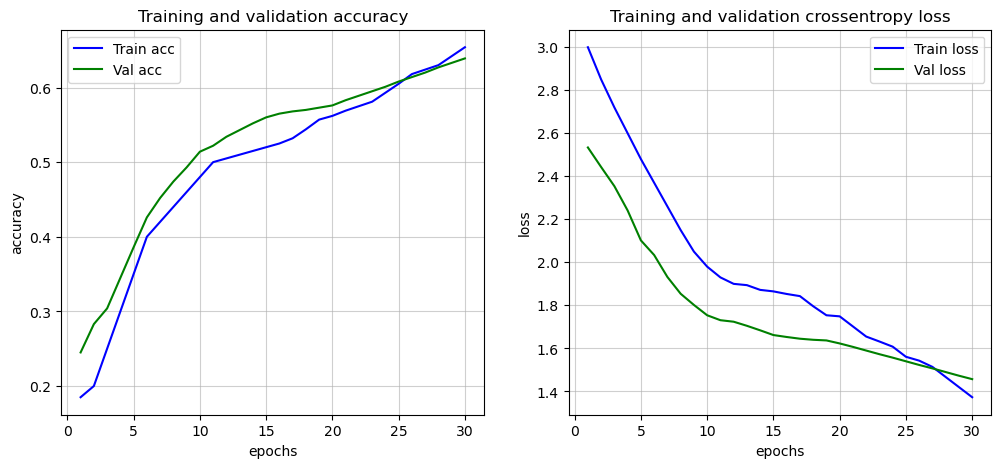

In [ ]:
plot_history_bert(history)

In [ ]:
complete_model = BertForSequenceClassification.from_pretrained('Rostlab/prot_bert', num_labels = len(labels_dict),
                                                           output_attentions=False, output_hidden_states=False)
complete_model.load_state_dict(torch.load('pdb/best_finetuned_ProtBERT.pth'))
complete_model.to(device)

In [ ]:
test_loss, test_predicted_vals, test_true_vals = model_evaluate(complete_model, test_data_loader_prot)
test_f1_score, test_f1_per_class, test_acc = my_metrics(test_true_vals, test_predicted_vals)
test_macro_f1_score = f1_score(true_labels, predicted, average = 'macro')
print(f'Test loss: {test_loss}')
print(f'Test Acc: {test_acc}')
print(f'Test F1 Score(Weighted): {test_f1_score}')
print(f'Test F1 Score(Macro): {test_macro_f1_score}')

Test loss: 1.52976742
Test Acc: 0.612446662
Test F1 Score(Weighted): 0.56676742
Test F1 Score(Macro): 0.5243267



## Comparison of BERT Models

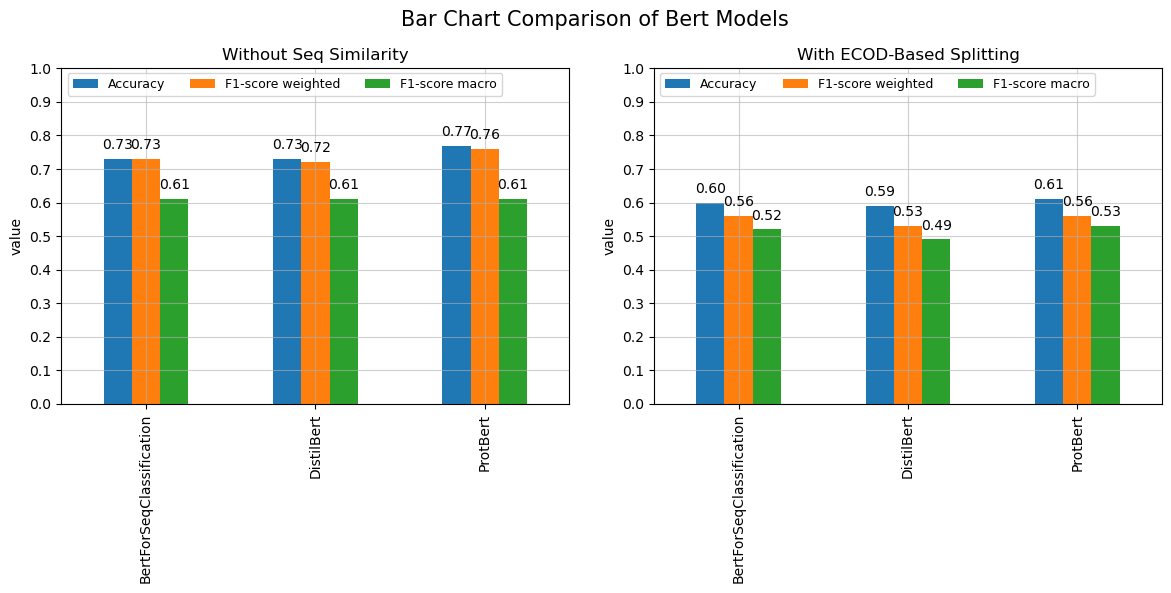

In [ ]:
models = ['BertForSeqClassification', 'DistilBert', 'ProtBert']
# without similarity
acc = [0.73,  0.73, 0.77]
f1 = [0.73, 0.72, 0.76]
macro_f1 = [0.61, 0.61, 0.61]

#with ecod based splitting
acc_we = [0.60,  0.59, 0.61]
f1_we = [0.56, 0.53, 0.56]
macro_f1_we = [0.52, 0.49, 0.53]

matrics_dict = {'Accuracy': acc, 'F1-Score weighted': f1, 'F1-Score macro': macro_f1}  # 'Models': model,

model_df = pd.DataFrame(matrics_dict.values(), columns = models).T
model_df.columns = ['Accuracy', 'F1-score weighted', 'F1-score macro']
model_df = model_df.sort_values(by = ['F1-score macro'], ascending = False)

matrics_dict_we = {'Accuracy': acc_we, 'F1-Score weighted': f1_we, 'F1-Score macro': macro_f1_we}  # 'Models': model,

model_df_we = pd.DataFrame(matrics_dict_we.values(), columns = models).T
model_df_we.columns = ['Accuracy', 'F1-score weighted', 'F1-score macro']
# model_df_we = model_df_we.sort_values(by = ['F1-score macro'], ascending = False)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Without ECOD
ax1 = model_df.plot(kind='bar', ax=axes[0], title="Without Seq Similarity")
ax1.legend(ncol=len(models), bbox_to_anchor=(0, 0.9), loc='lower left', prop={'size': 9})
# ax1.legend()
for p in ax1.patches:
    ax1.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax1.set_yticks(np.arange(0, 1.1, step=0.1))
ax1.set_ylabel("value")
ax1.grid(alpha=0.6)

# With ECOD
ax2 = model_df_we.plot(kind='bar', ax=axes[1], title="With ECOD-Based Splitting")
ax2.legend(ncol=len(models), bbox_to_anchor=(0, 0.9), loc='lower left', prop={'size': 9})
# ax2.legend()
for p in ax2.patches:
    ax2.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax2.set_yticks(np.arange(0, 1.1, step=0.1))
ax2.set_ylabel("value")
ax2.grid(alpha=0.6)

plt.suptitle("Bar Chart Comparison of Bert Models", fontsize=15)
plt.tight_layout()
plt.show()

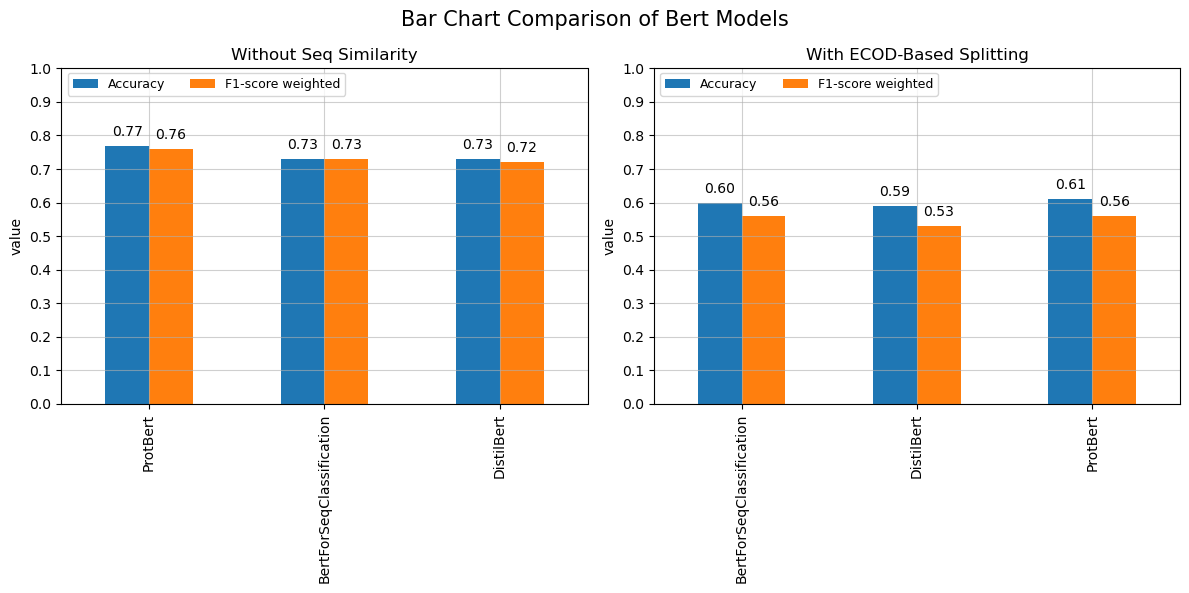

In [ ]:
models = ['BertForSeqClassification', 'DistilBert', 'ProtBert']
# without similarity
acc = [0.73,  0.73, 0.77]
f1 = [0.73, 0.72, 0.76]

#with ecod based splitting
acc_we = [0.60,  0.59, 0.61]
f1_we = [0.56, 0.53, 0.56]

matrics_dict = {'Accuracy': acc, 'F1-Score weighted': f1}  # 'Models': model,

model_df = pd.DataFrame(matrics_dict.values(), columns = models).T
model_df.columns = ['Accuracy', 'F1-score weighted']
model_df = model_df.sort_values(by = ['F1-score weighted'], ascending = False)

matrics_dict_we = {'Accuracy': acc_we, 'F1-Score weighted': f1_we}  # 'Models': model,

model_df_we = pd.DataFrame(matrics_dict_we.values(), columns = models).T
model_df_we.columns = ['Accuracy', 'F1-score weighted']
# model_df_we = model_df_we.sort_values(by = ['F1-score macro'], ascending = False)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Without ECOD
ax1 = model_df.plot(kind='bar', ax=axes[0], title="Without Seq Similarity")
ax1.legend(ncol=len(models), bbox_to_anchor=(0, 0.9), loc='lower left', prop={'size': 9})
# ax1.legend()
for p in ax1.patches:
    ax1.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax1.set_yticks(np.arange(0, 1.1, step=0.1))
ax1.set_ylabel("value")
ax1.grid(alpha=0.6)

# With ECOD
ax2 = model_df_we.plot(kind='bar', ax=axes[1], title="With ECOD-Based Splitting")
ax2.legend(ncol=len(models), bbox_to_anchor=(0, 0.9), loc='lower left', prop={'size': 9})
# ax2.legend()
for p in ax2.patches:
    ax2.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax2.set_yticks(np.arange(0, 1.1, step=0.1))
ax2.set_ylabel("value")
ax2.grid(alpha=0.6)

plt.suptitle("Bar Chart Comparison of Bert Models", fontsize=15)
plt.tight_layout()
plt.show()

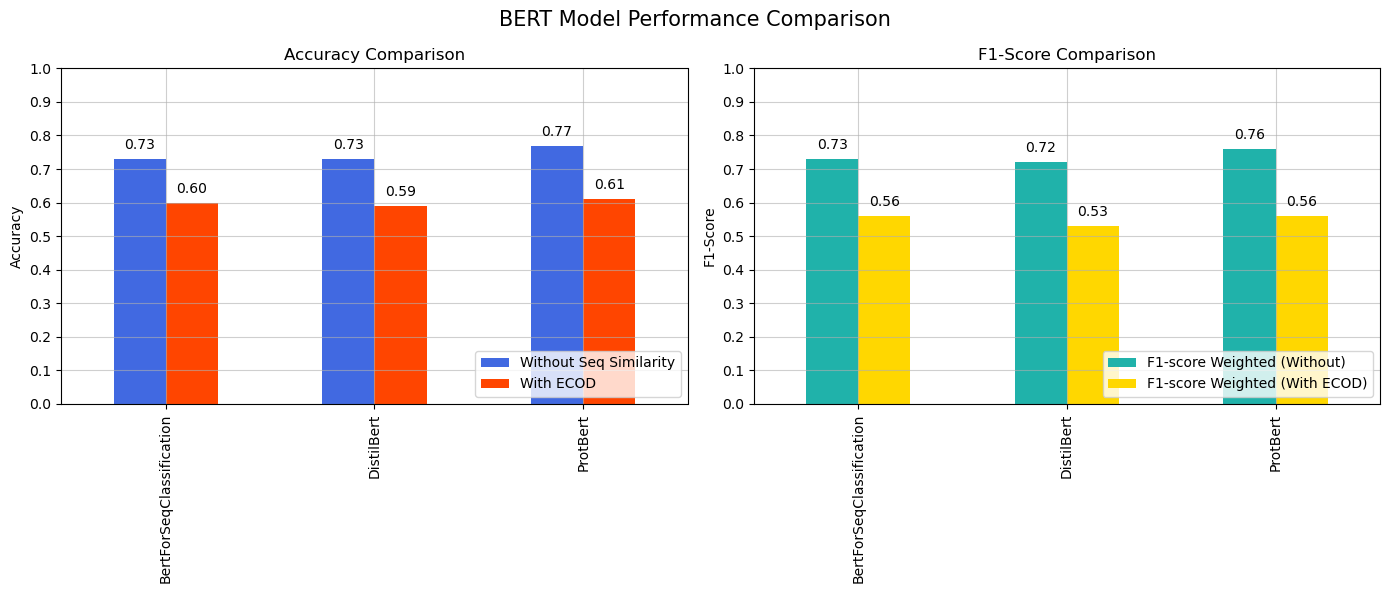

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define models
models = ['BertForSeqClassification', 'DistilBert', 'ProtBert']

# Without seq similarity
acc = [0.73, 0.73, 0.77]
f1_weighted = [0.73, 0.72, 0.76]
f1_macro = [0.61, 0.61, 0.61]

# With ECOD-based splitting
acc_we = [0.60,  0.59, 0.61]
f1_weighted_we = [0.56, 0.53, 0.56]
f1_macro_we = [0.52, 0.49, 0.53]

# Convert to DataFrame
acc_df = pd.DataFrame({'Without Seq Similarity': acc, 'With ECOD': acc_we}, index=models)
f1_df = pd.DataFrame({'F1-score Weighted (Without)': f1_weighted, 'F1-score Weighted (With ECOD)': f1_weighted_we}, index=models)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Accuracy comparison
ax1 = acc_df.plot(kind='bar', ax=axes[0], title="Accuracy Comparison", color=['royalblue', 'orangered'])
ax1.set_yticks(np.arange(0, 1.1, step=0.1))
ax1.set_ylabel("Accuracy")
ax1.grid(alpha=0.6)
ax1.legend(loc='lower right')

# Annotate bars
for p in ax1.patches:
    ax1.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

# Subplot 2: F1-score comparison
ax2 = f1_df.plot(kind='bar', ax=axes[1], title="F1-Score Comparison", color=['lightseagreen', 'gold']) # 'cornflowerblue', 'tomato',
ax2.set_yticks(np.arange(0, 1.1, step=0.1))
ax2.set_ylabel("F1-Score")
ax2.grid(alpha=0.6)
ax2.legend(loc='lower right')

# Annotate bars
for p in ax2.patches:
    ax2.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.suptitle("BERT Model Performance Comparison", fontsize=15)
plt.tight_layout()

plt.savefig("figure4.tiff", format="tiff", dpi=300, bbox_inches='tight', transparent=False)

plt.show()


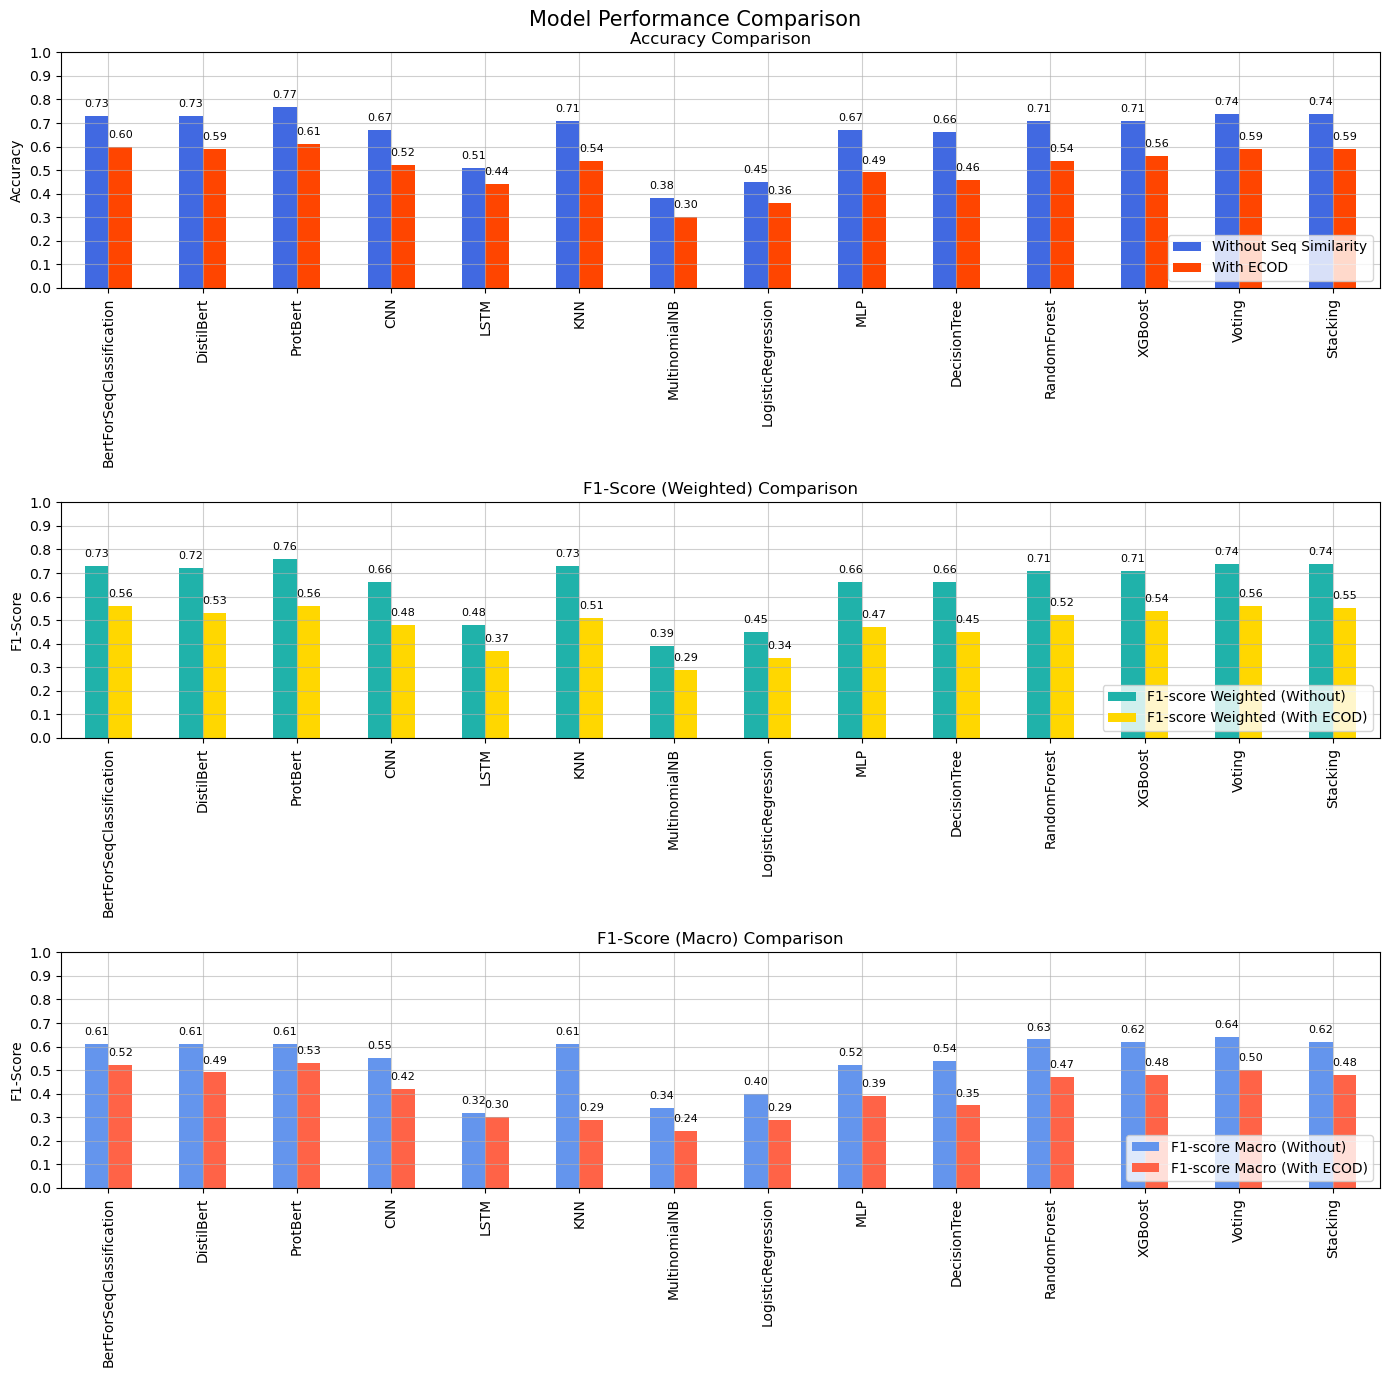

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define models
models = ['BertForSeqClassification', 'DistilBert', 'ProtBert', 'CNN', 'LSTM', 'KNN',
         'MultinomialNB', 'LogisticRegression', 'MLP', 'DecisionTree', 'RandomForest', 'XGBoost', 'Voting', 'Stacking']

# Without seq similarity
acc = [0.73, 0.73, 0.77, 0.67, 0.51, 0.71, 0.38, 0.45, 0.67, 0.66, 0.71, 0.71, 0.74, 0.74]
f1_weighted = [0.73, 0.72, 0.76, 0.66, 0.48, 0.73, 0.39, 0.45, 0.66, 0.66, 0.71, 0.71, 0.74, 0.74]
f1_macro = [0.61, 0.61, 0.61, 0.55, 0.32, 0.61, 0.34, 0.40, 0.52, 0.54, 0.63, 0.62, 0.64, 0.62]

# With ECOD-based splitting
acc_we = [0.60, 0.59, 0.61, 0.52, 0.44, 0.54, 0.30, 0.36, 0.49, 0.46, 0.54, 0.56, 0.59, 0.59]
f1_weighted_we = [0.56, 0.53, 0.56, 0.48, 0.37, 0.51, 0.29, 0.34, 0.47, 0.45, 0.52, 0.54, 0.56, 0.55]
f1_macro_we = [0.52, 0.49, 0.53, 0.42, 0.30, 0.29, 0.24, 0.29, 0.39, 0.35, 0.47, 0.48, 0.50, 0.48]

# Convert to DataFrame
acc_df = pd.DataFrame({'Without Seq Similarity': acc, 'With ECOD': acc_we}, index=models)
f1_df = pd.DataFrame({'F1-score Weighted (Without)': f1_weighted, 'F1-score Weighted (With ECOD)': f1_weighted_we}, index=models)
macro_f1_df = pd.DataFrame({'F1-score Macro (Without)': f1_macro, 'F1-score Macro (With ECOD)': f1_macro_we}, index=models)

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(14, 14))

# Subplot 1: Accuracy comparison
ax1 = acc_df.plot(kind='bar', ax=axes[0], title="Accuracy Comparison", color=['royalblue', 'orangered'])
ax1.set_yticks(np.arange(0, 1.1, step=0.1))
ax1.set_ylabel("Accuracy")
ax1.grid(alpha=0.6)
ax1.legend(loc='lower right')

# Annotate bars
for p in ax1.patches:
    ax1.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontsize=8)

# Subplot 2: F1-score comparison
ax2 = f1_df.plot(kind='bar', ax=axes[1], title="F1-Score (Weighted) Comparison", color=['lightseagreen', 'gold']) # 'cornflowerblue', 'tomato',
ax2.set_yticks(np.arange(0, 1.1, step=0.1))
ax2.set_ylabel("F1-Score")
ax2.grid(alpha=0.6)
ax2.legend(loc='lower right')

# Annotate bars
for p in ax2.patches:
    ax2.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontsize=8)

# Subplot 3: F1-score comparison
ax3 = macro_f1_df.plot(kind='bar', ax=axes[2], title="F1-Score (Macro) Comparison", color=['cornflowerblue', 'tomato'])
ax3.set_yticks(np.arange(0, 1.1, step=0.1))
ax3.set_ylabel("F1-Score")
ax3.grid(alpha=0.6)
ax3.legend(loc='lower right')

# Annotate bars
for p in ax3.patches:
    ax3.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontsize=8)

plt.suptitle("Model Performance Comparison", fontsize=15)
plt.tight_layout()

plt.savefig("figure5.tiff", format="tiff", dpi=300, bbox_inches='tight', transparent=False)

plt.show()